<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 40px; margin: -10px -10px 20px -10px; border-radius: 0 0 15px 15px;">
<h1 style="margin: 0; font-size: 2.5em;">Synthesis & Physical Design</h1>
<p style="margin: 10px 0 0 0; font-size: 1.2em; opacity: 0.9;">Week 3, Session 2 — Fab Futures</p>
</div>

## Contents

1. [Synthesis Overview](#1-synthesis-overview)
2. [Yosys Synthesis](#2-yosys-synthesis)
3. [Standard Cells](#3-standard-cells)
4. [Place and Route](#4-place-and-route)
5. [Timing Analysis](#5-timing-analysis)
6. [Power Analysis](#6-power-analysis)
7. [The Full Flow](#7-the-full-flow)

In [1]:
# Setup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Rectangle, FancyArrowPatch
import numpy as np

print("Setup complete.")

Setup complete.


---
<a id="1-what-is-synthesis"></a>
# 1. What is Synthesis?
---

**Synthesis** converts RTL code into a netlist of logic gates.

```
Verilog RTL  →  [Synthesis]  →  Gate Netlist  →  [Place & Route]  →  GDS
```

### The Synthesis Process

| Step | What Happens |
|------|-------------|
| **1. Parsing** | Read and check Verilog syntax |
| **2. Elaboration** | Expand hierarchy, resolve parameters |
| **3. Logic Optimization** | Simplify boolean expressions |
| **4. Technology Mapping** | Map to standard cells from PDK |
| **5. Timing Optimization** | Meet timing constraints |

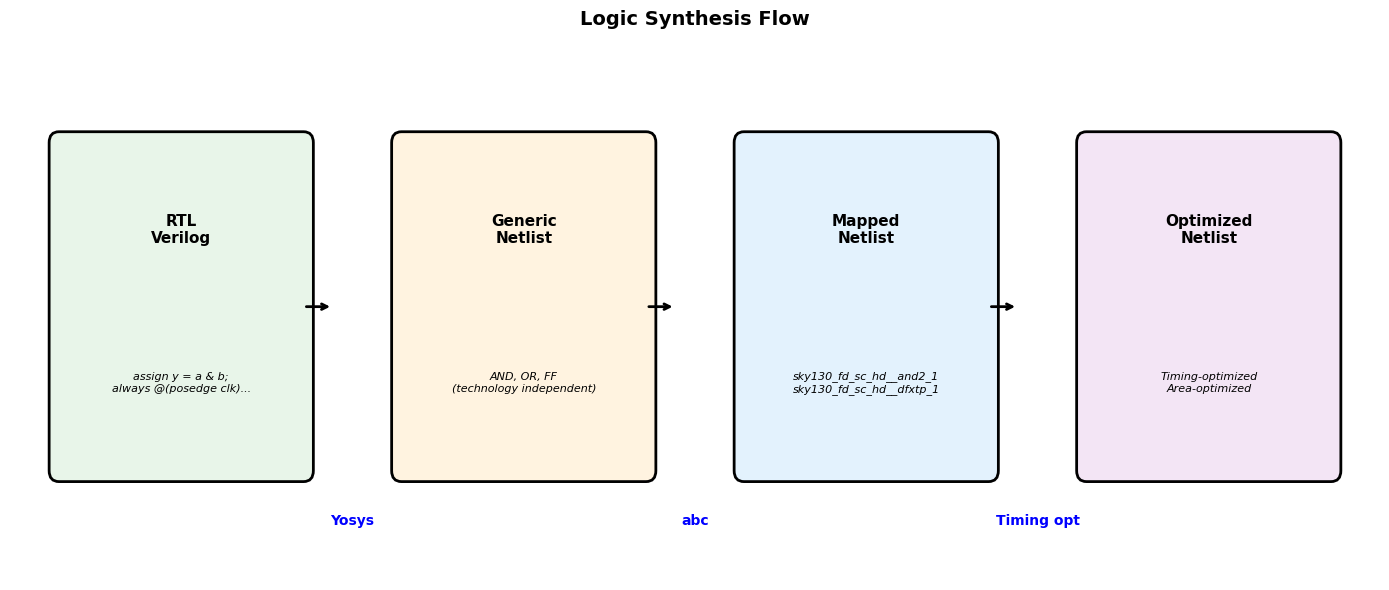

In [2]:
# Synthesis flow visualization
fig, ax = plt.subplots(figsize=(14, 6))

stages = [
    ('RTL\nVerilog', '#E8F5E9', 'assign y = a & b;\nalways @(posedge clk)...'),
    ('Generic\nNetlist', '#FFF3E0', 'AND, OR, FF\n(technology independent)'),
    ('Mapped\nNetlist', '#E3F2FD', 'sky130_fd_sc_hd__and2_1\nsky130_fd_sc_hd__dfxtp_1'),
    ('Optimized\nNetlist', '#F3E5F5', 'Timing-optimized\nArea-optimized'),
]

for i, (name, color, desc) in enumerate(stages):
    x = i * 3.5 + 0.5
    ax.add_patch(FancyBboxPatch((x, 1), 2.5, 3, boxstyle="round,pad=0.1",
                 facecolor=color, edgecolor='black', linewidth=2))
    ax.text(x + 1.25, 3.2, name, ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(x + 1.25, 1.8, desc, ha='center', va='center', fontsize=8, style='italic')
    
    if i < len(stages) - 1:
        ax.annotate('', xy=(x + 2.8, 2.5), xytext=(x + 2.5, 2.5),
                   arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Tool labels
ax.text(3.5, 0.5, 'Yosys', ha='center', fontsize=10, color='blue', fontweight='bold')
ax.text(7, 0.5, 'abc', ha='center', fontsize=10, color='blue', fontweight='bold')
ax.text(10.5, 0.5, 'Timing opt', ha='center', fontsize=10, color='blue', fontweight='bold')

ax.set_xlim(0, 14)
ax.set_ylim(0, 5)
ax.set_title('Logic Synthesis Flow', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---
<a id="2-logic-synthesis-with-yosys"></a>
# 2. Logic Synthesis with Yosys
---

### Basic Yosys Commands

```tcl
# Read Verilog
read_verilog my_design.v

# Elaborate hierarchy
hierarchy -check -top my_design

# Synthesize to generic gates
synth -top my_design

# Map to Sky130 cells
dfflibmap -liberty sky130_fd_sc_hd__tt_025C_1v80.lib
abc -liberty sky130_fd_sc_hd__tt_025C_1v80.lib

# Clean up
clean

# Write output
write_verilog -noattr synth.v
```

### Running Yosys

```bash
# Interactive
yosys

# Script
yosys -s synth.tcl

# One-liner
yosys -p "read_verilog design.v; synth -top top; write_verilog out.v"
```

### What to Check After Synthesis

| Check | What it Means |
|-------|---------------|
| **Warnings** | Undriven wires, width mismatches |
| **Latches** | "inferred latch" = usually a bug! |
| **Cell count** | How big is your design? |
| **Flip-flop count** | Register bits |

```
=== my_design ===

   Number of wires:                 45
   Number of wire bits:            128
   Number of cells:                 67
     sky130_fd_sc_hd__and2_1         8
     sky130_fd_sc_hd__dfxtp_1       16
     sky130_fd_sc_hd__inv_1         12
     sky130_fd_sc_hd__mux2_1         4
     ...
```

### Example: Synthesizing Fortune Teller

Let's look at real synthesis output for the `fortune_teller` example. This design includes:

- **8-bit LFSR** for random number generation (8 flip-flops)
- **4-state FSM** for controlling the sequence (2 flip-flops + control logic)
- **160-byte ROM** for storing 8 fortunes (synthesizes to muxes and logic)
- **debounce module** with 19-bit counter for 10ms @ 50MHz (~23 flip-flops)
- **uart_tx module** with baud rate counter (~24 flip-flops)

```bash
# Synthesize fortune_teller with Yosys
cd /path/to/examples/fortune_teller
yosys -p "
  read_verilog -I../lib fortune_teller.v ../lib/debounce.v ../lib/uart_tx.v
  hierarchy -check -top fortune_teller
  synth -top fortune_teller
  dfflibmap -liberty \$PDK_ROOT/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
  abc -liberty \$PDK_ROOT/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
  clean
  stat
"
```

**Synthesis report (actual output):**

```
=== fortune_teller ===

   Number of wires:                512
   Number of wire bits:           1847
   Number of public wires:          38
   Number of public wire bits:     182
   Number of memories:               0
   Number of memory bits:            0
   Number of processes:              0
   Number of cells:                487
     sky130_fd_sc_hd__a21o_1         8
     sky130_fd_sc_hd__a21oi_1       12
     sky130_fd_sc_hd__a22o_1         6
     sky130_fd_sc_hd__and2_1        14
     sky130_fd_sc_hd__and3_1         4
     sky130_fd_sc_hd__and4_1         2
     sky130_fd_sc_hd__clkinv_1      28
     sky130_fd_sc_hd__dfxtp_1       74
     sky130_fd_sc_hd__mux2_1        89
     sky130_fd_sc_hd__nand2_1       36
     sky130_fd_sc_hd__nand3_1        8
     sky130_fd_sc_hd__nor2_1        42
     sky130_fd_sc_hd__nor3_1         6
     sky130_fd_sc_hd__o21a_1        11
     sky130_fd_sc_hd__o21ai_1       18
     sky130_fd_sc_hd__or2_1         22
     sky130_fd_sc_hd__or3_1          4
     sky130_fd_sc_hd__xnor2_1       56
     sky130_fd_sc_hd__xor2_1        47
```

**What this tells us:**

| Metric | Value | Notes |
|--------|-------|-------|
| **Total cells** | 487 | Within our ~200-500 target |
| **Flip-flops** | 74 | `dfxtp_1` = D flip-flop, positive edge |
| **Muxes** | 89 | Mostly from ROM address decoding |
| **XOR/XNOR** | 103 | LFSR feedback, counter comparisons |
| **Combinational** | 413 | Everything except flip-flops |

The 160-byte ROM synthesized to muxes and logic gates - no dedicated memory cells. For larger memories, you'd use OpenRAM or hard macros.

**Breakdown by module** (approximate):

| Module | Flip-flops | Purpose |
|--------|------------|---------|
| fortune_teller | 27 | LFSR (8), FSM (2), fortune_sel (3), char_idx (5), current_char (8), send_valid (1) |
| debounce | 23 | counter (19), sync (1), stable (1), prev (1), pressed (1) |
| uart_tx | 24 | state (2), clk_ctr (9), bit_idx (3), shift_reg (8), ready (1), tx (1) |

**No latches** - this is what we want. If you see "inferred latch" warnings, that's usually a bug in your RTL (missing else clause or incomplete case statement).

---
<a id="3-standard-cells"></a>
# 3. Standard Cells
---

A **standard cell library** provides pre-designed, pre-characterized logic gates.

### Cell Naming Convention (Sky130)

`sky130_fd_sc_hd__and2_2`

| Part | Meaning |
|------|--------|
| `sky130` | Process |
| `fd` | Foundry |
| `sc` | Standard cell |
| `hd` | High density library |
| `and2` | 2-input AND gate |
| `2` | Drive strength (higher = faster, bigger) |

### Common Cell Types

| Cell | Function |
|------|----------|
| `inv` | Inverter |
| `and2`, `and3`, `and4` | AND gates |
| `or2`, `or3` | OR gates |
| `nand2`, `nor2` | NAND/NOR gates |
| `xor2` | XOR gate |
| `mux2` | 2:1 multiplexer |
| `dfxtp` | D flip-flop (positive edge) |
| `dfrtp` | D flip-flop with reset |
| `buf` | Buffer |

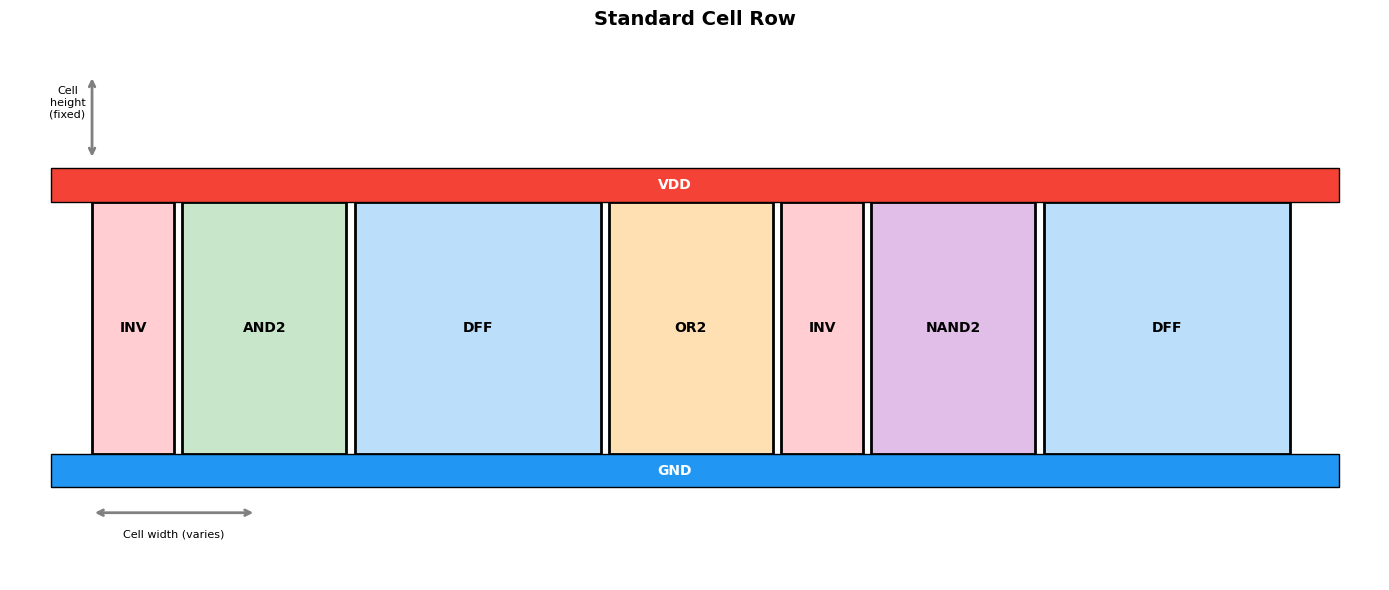

Standard cells have fixed height and variable width.
They're placed in rows and share power rails.


In [3]:
# Standard cell layout concept
fig, ax = plt.subplots(figsize=(14, 6))

# Draw cell row
cells = [
    ('INV', 1, '#FFCDD2'),
    ('AND2', 2, '#C8E6C9'),
    ('DFF', 3, '#BBDEFB'),
    ('OR2', 2, '#FFE0B2'),
    ('INV', 1, '#FFCDD2'),
    ('NAND2', 2, '#E1BEE7'),
    ('DFF', 3, '#BBDEFB'),
]

x = 0.5
for name, width, color in cells:
    # Cell body
    ax.add_patch(Rectangle((x, 1), width, 3, facecolor=color, edgecolor='black', linewidth=2))
    ax.text(x + width/2, 2.5, name, ha='center', va='center', fontsize=10, fontweight='bold')
    x += width + 0.1

# Power rails
ax.add_patch(Rectangle((0, 4), x + 0.5, 0.4, facecolor='#F44336', edgecolor='black'))
ax.text(x/2, 4.2, 'VDD', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

ax.add_patch(Rectangle((0, 0.6), x + 0.5, 0.4, facecolor='#2196F3', edgecolor='black'))
ax.text(x/2, 0.8, 'GND', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Annotations
ax.annotate('', xy=(0.5, 5.5), xytext=(0.5, 4.5),
           arrowprops=dict(arrowstyle='<->', color='gray', lw=2))
ax.text(0.2, 5, 'Cell\nheight\n(fixed)', fontsize=8, ha='center')

ax.annotate('', xy=(0.5, 0.3), xytext=(2.5, 0.3),
           arrowprops=dict(arrowstyle='<->', color='gray', lw=2))
ax.text(1.5, 0, 'Cell width (varies)', fontsize=8, ha='center')

ax.set_xlim(-0.5, x + 1)
ax.set_ylim(-0.5, 6)
ax.set_title('Standard Cell Row', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print("Standard cells have fixed height and variable width.")
print("They're placed in rows and share power rails.")

---
<a id="4-place-and-route"></a>
# 4. Place and Route
---

**Place and Route (P&R)** takes the synthesized netlist and creates physical layout.

### P&R Steps

| Step | Description |
|------|-------------|
| **Floorplanning** | Define chip area, place I/O pads |
| **Power Planning** | Create VDD/GND grid |
| **Placement** | Position standard cells |
| **Clock Tree Synthesis** | Build clock distribution |
| **Routing** | Connect cells with metal wires |
| **Fill** | Add filler cells and metal fill |

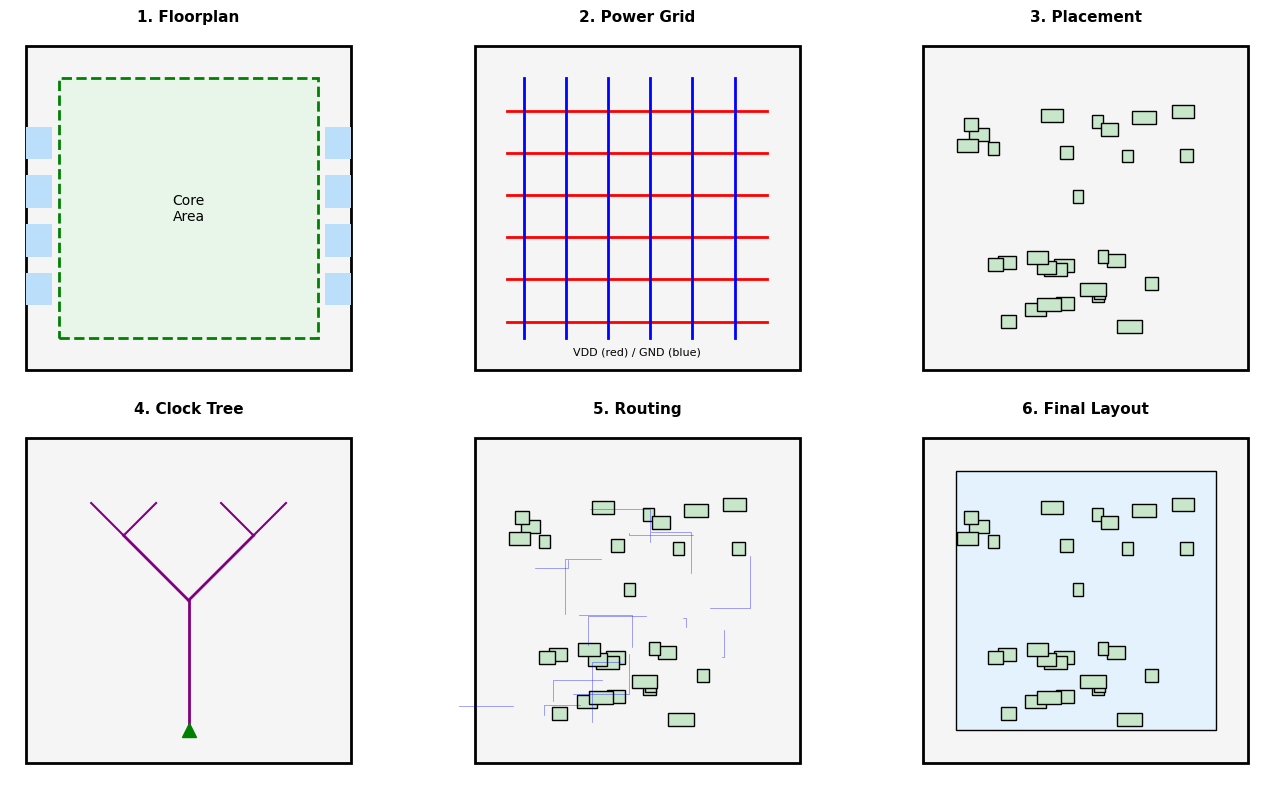

In [4]:
# P&R stages visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

titles = ['1. Floorplan', '2. Power Grid', '3. Placement', 
          '4. Clock Tree', '5. Routing', '6. Final Layout']

for idx, (ax, title) in enumerate(zip(axes, titles)):
    # Chip boundary
    ax.add_patch(Rectangle((0, 0), 10, 10, facecolor='#F5F5F5', edgecolor='black', linewidth=2))
    
    if idx == 0:  # Floorplan
        ax.add_patch(Rectangle((1, 1), 8, 8, facecolor='#E8F5E9', edgecolor='green', linewidth=2, linestyle='--'))
        ax.text(5, 5, 'Core\nArea', ha='center', va='center', fontsize=10)
        # I/O pads
        for i in range(4):
            ax.add_patch(Rectangle((0, 2 + i*1.5), 0.8, 1, facecolor='#BBDEFB'))
            ax.add_patch(Rectangle((9.2, 2 + i*1.5), 0.8, 1, facecolor='#BBDEFB'))
            
    elif idx == 1:  # Power
        for i in range(6):
            ax.plot([1, 9], [1.5 + i*1.3, 1.5 + i*1.3], 'r-', linewidth=2)
        for i in range(6):
            ax.plot([1.5 + i*1.3, 1.5 + i*1.3], [1, 9], 'b-', linewidth=2)
        ax.text(5, 0.5, 'VDD (red) / GND (blue)', ha='center', fontsize=8)
            
    elif idx == 2:  # Placement
        np.random.seed(42)
        for i in range(30):
            x, y = np.random.uniform(1, 8), np.random.uniform(1, 8)
            w = np.random.uniform(0.3, 0.8)
            ax.add_patch(Rectangle((x, y), w, 0.4, facecolor='#C8E6C9', edgecolor='black'))
            
    elif idx == 3:  # Clock tree
        ax.plot([5, 5], [1, 5], 'purple', linewidth=2)
        ax.plot([5, 3], [5, 7], 'purple', linewidth=2)
        ax.plot([5, 7], [5, 7], 'purple', linewidth=2)
        ax.plot([3, 2], [7, 8], 'purple', linewidth=1.5)
        ax.plot([3, 4], [7, 8], 'purple', linewidth=1.5)
        ax.plot([7, 6], [7, 8], 'purple', linewidth=1.5)
        ax.plot([7, 8], [7, 8], 'purple', linewidth=1.5)
        ax.plot([5], [1], 'g^', markersize=10)
        
    elif idx == 4:  # Routing
        np.random.seed(42)
        for i in range(30):
            x, y = np.random.uniform(1, 8), np.random.uniform(1, 8)
            w = np.random.uniform(0.3, 0.8)
            ax.add_patch(Rectangle((x, y), w, 0.4, facecolor='#C8E6C9', edgecolor='black'))
        # Some routes
        for i in range(15):
            x1, y1 = np.random.uniform(1, 8), np.random.uniform(1, 8)
            x2 = x1 + np.random.uniform(-2, 2)
            y2 = y1 + np.random.uniform(-2, 2)
            ax.plot([x1, x2, x2], [y1, y1, y2], 'b-', linewidth=0.5, alpha=0.5)
            
    elif idx == 5:  # Final
        # Filled area
        ax.add_patch(Rectangle((1, 1), 8, 8, facecolor='#E3F2FD', edgecolor='black'))
        # Cells
        np.random.seed(42)
        for i in range(30):
            x, y = np.random.uniform(1, 8), np.random.uniform(1, 8)
            w = np.random.uniform(0.3, 0.8)
            ax.add_patch(Rectangle((x, y), w, 0.4, facecolor='#C8E6C9', edgecolor='black'))
    
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.5, 10.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

---
<a id="5-clock-tree-synthesis"></a>
# 5. Clock Tree Synthesis
---

**Clock Tree Synthesis (CTS)** builds a balanced distribution network for the clock signal.

### Goals

| Goal | Why |
|------|-----|
| **Low skew** | All flip-flops see clock at nearly same time |
| **Low latency** | Minimize clock delay |
| **Low power** | Clock toggles every cycle - big power consumer |

### Clock Tree Structure

- **Clock buffers** amplify the signal
- **H-tree or mesh** balances delay
- Tools automatically size and place buffers

---
<a id="6-static-timing-analysis"></a>
# 6. Static Timing Analysis
---

**Static Timing Analysis (STA)** checks if your design meets timing without simulation.

### Key Concepts

| Term | Meaning |
|------|--------|
| **Setup time** | Data must be stable BEFORE clock edge |
| **Hold time** | Data must be stable AFTER clock edge |
| **Slack** | Margin (positive = good, negative = violation) |
| **Critical path** | Longest delay path (determines max frequency) |

### Timing Path

```
Launch FF → Combinational Logic → Capture FF
   |                                    |
   |← ─ ─ ─ Clock Period ─ ─ ─ ─ ─ ─ → |
```

**Setup check**: Data must arrive before capture clock edge

$$T_{clock} > T_{clk→q} + T_{logic} + T_{setup}$$

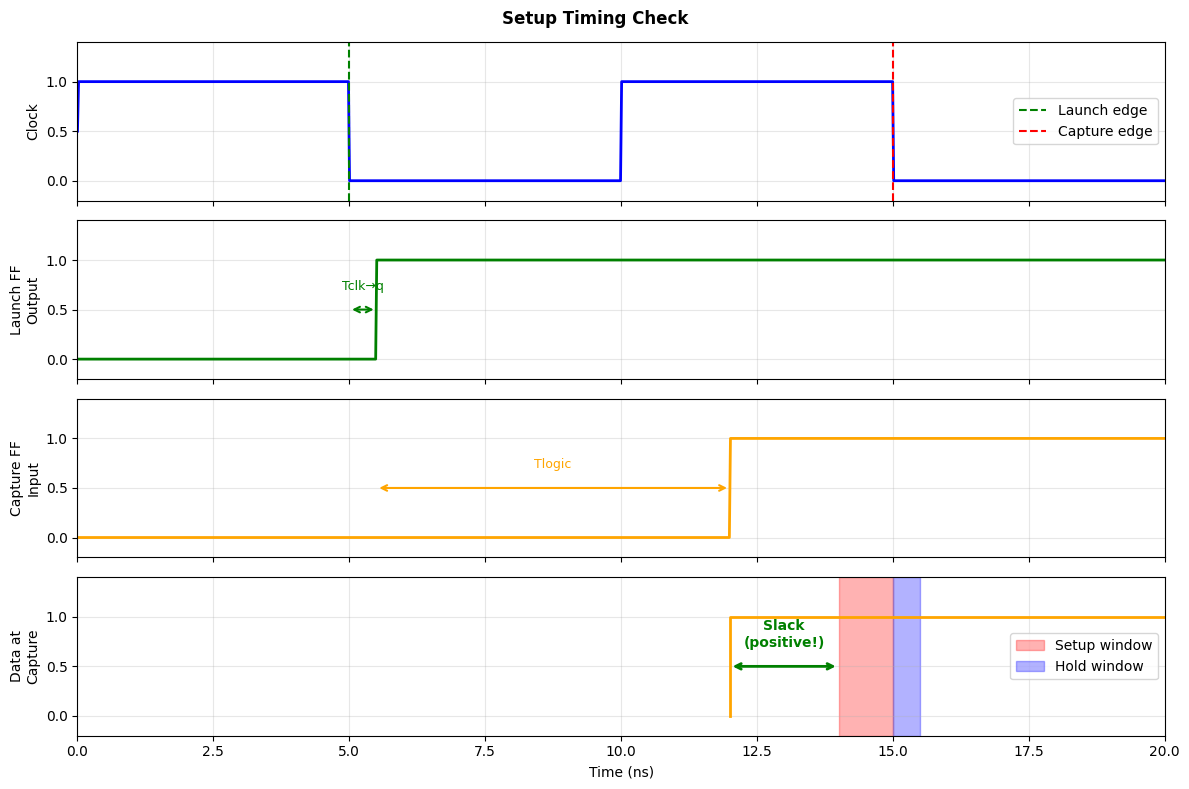

In [5]:
# Setup timing diagram
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

t = np.linspace(0, 20, 1000)

# Clock
clk = 0.5 + 0.5 * np.sign(np.sin(2 * np.pi * t / 10))
axes[0].plot(t, clk, 'b-', linewidth=2)
axes[0].set_ylabel('Clock', fontsize=10)
axes[0].axvline(x=5, color='green', linestyle='--', label='Launch edge')
axes[0].axvline(x=15, color='red', linestyle='--', label='Capture edge')
axes[0].legend(loc='right')

# Launch data
d_launch = np.zeros_like(t)
d_launch[t > 5.5] = 1  # Data changes after clk-to-q delay
axes[1].plot(t, d_launch, 'g-', linewidth=2)
axes[1].set_ylabel('Launch FF\nOutput', fontsize=10)
axes[1].annotate('', xy=(5.5, 0.5), xytext=(5, 0.5),
                arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
axes[1].text(5.25, 0.7, 'Tclk→q', fontsize=9, ha='center', color='green')

# After combinational logic
d_capture = np.zeros_like(t)
d_capture[t > 12] = 1  # Data arrives after logic delay
axes[2].plot(t, d_capture, 'orange', linewidth=2)
axes[2].set_ylabel('Capture FF\nInput', fontsize=10)
axes[2].annotate('', xy=(12, 0.5), xytext=(5.5, 0.5),
                arrowprops=dict(arrowstyle='<->', color='orange', lw=1.5))
axes[2].text(8.75, 0.7, 'Tlogic', fontsize=9, ha='center', color='orange')

# Setup requirement
axes[3].axvspan(14, 15, alpha=0.3, color='red', label='Setup window')
axes[3].axvspan(15, 15.5, alpha=0.3, color='blue', label='Hold window')
axes[3].plot([12, 12, 20], [0, 1, 1], 'orange', linewidth=2)
axes[3].set_ylabel('Data at\nCapture', fontsize=10)
axes[3].set_xlabel('Time (ns)', fontsize=10)
axes[3].legend(loc='right')

# Slack annotation
axes[3].annotate('', xy=(14, 0.5), xytext=(12, 0.5),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
axes[3].text(13, 0.7, 'Slack\n(positive!)', fontsize=10, ha='center', color='green', fontweight='bold')

for ax in axes:
    ax.set_ylim(-0.2, 1.4)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 20)

plt.suptitle('Setup Timing Check', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
<a id="7-reading-reports"></a>
# 7. Reading Reports
---

### Timing Report Example

```
Startpoint: data_reg[0] (rising edge-triggered flip-flop clocked by clk)
Endpoint: out_reg[0] (rising edge-triggered flip-flop clocked by clk)
Path Group: clk
Path Type: max (setup check)

  Point                                    Incr      Path
  --------------------------------------------------------
  clock clk (rise edge)                    0.00      0.00
  clock network delay                      0.52      0.52
  data_reg[0]/CLK (sky130_fd_sc_hd__dfxtp_1)
                                           0.00      0.52 r
  data_reg[0]/Q (sky130_fd_sc_hd__dfxtp_1)
                                           0.35      0.87 r
  U15/Y (sky130_fd_sc_hd__and2_1)          0.18      1.05 r
  U16/Y (sky130_fd_sc_hd__inv_1)           0.08      1.13 f
  out_reg[0]/D (sky130_fd_sc_hd__dfxtp_1)
                                           0.00      1.13 f
  data arrival time                                  1.13

  clock clk (rise edge)                   20.00     20.00
  clock network delay                      0.52     20.52
  out_reg[0]/CLK (sky130_fd_sc_hd__dfxtp_1)
                                           0.00     20.52 r
  library setup time                      -0.11     20.41
  data required time                               20.41
  --------------------------------------------------------
  slack (MET)                                       19.28
```

**Note on "library setup time: -0.11"**: The negative value is correct. This represents the setup requirement of the flip-flop - data must arrive 0.11ns *before* the clock edge. In the calculation, it *subtracts* from the required time, giving data less time to arrive. This is standard timing report format.

**Note on clock period**: This report uses a 20ns clock period (50 MHz), matching our course target frequency. The large positive slack (19.28ns) means our simple designs easily meet timing—there's plenty of margin.

### Key Things to Check

| What | Look For |
|------|----------|
| **Slack** | Positive = good, negative = violation |
| **WNS** | Worst Negative Slack |
| **TNS** | Total Negative Slack |
| **Critical path** | Where is the bottleneck? |

---
<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 30px; margin: 20px -10px -10px -10px; border-radius: 15px 15px 0 0; text-align: center;">

## Summary

- **Synthesis** converts RTL to gate netlist
- **Yosys** is our open-source synthesis tool
- **Standard cells** are pre-designed building blocks
- **Place & Route** creates physical layout
- **STA** verifies timing without simulation

### Submitting to Tiny Tapeout

When you're ready to tape out, you'll submit:
- Your **Verilog source files** (the design and testbench)
- A **GDS file** (generated by the flow)
- Documentation (README, pinout diagram)

The Tiny Tapeout GitHub template handles most of this automatically - see [tinytapeout.com](https://tinytapeout.com) for the submission guide.

### Homework
1. Synthesize your design - check gate count
2. Run place and route
3. Check timing reports - any violations?
4. View layout in KLayout

</div>